In [1]:
import skorch
import torch
import torch.nn as nn

from math import ceil
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sine_data import train_dataset, valid_dataset

In [23]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=200)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [24]:
class ClipBPTTWrapper(nn.Module):
    def __init__(self, rnn_layer, hidden_dim, time_steps):
        super().__init__()
        self.rnn_layer = rnn_layer
        self.hidden_dim = hidden_dim
        self.time_steps = time_steps
        
    def init_hidden(self, batch_size, use_cuda):
        v = Variable(torch.zeros(self.hidden_dim, batch_size, self.hidden_dim))
        return v.cuda() if use_cuda else v
    
    def repack(self, h):
        v = Variable(h.data)
        return v.cuda() if h.is_cuda else v
    
    def rnn(self, x, h):
        return self.rnn_layer(x, h)
        
    def forward(self, x):
        num_steps = ceil(x.size(1) / self.time_steps)
        chunks = torch.chunk(x, num_steps, dim=1)
        h = self.init_hidden(x.size(0), x.is_cuda)
        ys = []
        
        for chunk in chunks:
            h = self.repack(h) # limit backprop to one chunk
            y, h = self.rnn(chunk, h)
            ys.append(y[:,-1])
        return torch.stack(ys, dim=1), h

In [25]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [66]:
class RepeatingRNN(nn.Module):
    def __init__(self, rnn_layer):
        super().__init__()
        self.rnn_layer = rnn_layer
        
    def forward(self, x, target_length):
        repeats = ceil(target_length / x.size(1))
                
        parts = []
        for ti in range(x.size(1)):
            xr = x[:, ti:(ti+1)].repeat(1, repeats, 1)
            parts.append(xr)
        
        x_rep = torch.cat(parts, dim=1)
        y, h = self.rnn_layer(x_rep)
        return y[:, :target_length], h
        
        x = x.repeat(1, repeats, 1)
        y, h = self.rnn_layer(x)
        return y[:, :target_length], h

In [67]:
class ReconModel(nn.Module):
    def __init__(
        self, 
        num_hidden=16, 
        num_timesteps_per_chunk_0=20, 
        num_timesteps_per_chunk_1=2, 
        baseline=False,
    ):
        super().__init__()
        
        # t -> ceil(t/20) timesteps
        layer_0 = nn.GRU(1, num_hidden, batch_first=True)
        self.rnn_enc_0 = ClipBPTTWrapper(layer_0, num_hidden, num_timesteps_per_chunk_0)
        
        # ceil(t/20) -> ceil(ceil(t/20)/2) timesteps
        #layer_1 = nn.GRU(num_hidden, num_hidden, batch_first=True)
        #self.rnn_enc_1 = ClipBPTTWrapper(layer_1, num_hidden, num_timesteps_per_chunk_1)
        
        # ceil(ceil(t/20)/2) chunks total as hidden repr. (3 for t=100)
        # so we now want 3 -> 100 again (recon task)
        # we do this by generating 100//3 for each chunk
        layer_2 = nn.GRU(num_hidden, num_hidden)
        self.rnn_dec_1 = RepeatingRNN(layer_2)
        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0 = self.rnn_enc_0(x)
        #l1, h1 = self.rnn_enc_1(l0)
        l2, h2 = self.rnn_dec_1(l0, x.size(1))
        print('l2', l2.size())
        clf = self.clf(l2)
        return time_unflatten(clf, x.size())

In [68]:
class Trainer(skorch.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

## with clip

In [69]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_with = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.005,
             max_epochs=120,
             train_split=my_train_split,
             
             module__num_hidden=16,
             module__num_timesteps_per_chunk_0=20,
             module__num_timesteps_per_chunk_1=5,
            )

In [70]:
%pdb on
ef_with.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0781        0.9959  0.2162
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
      2        0.9875        0.9329  0.2555
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
      3        0.9084        0.8766  0.2786
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
      4        0.8387        0.8270  0.2549
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
      5        0.7787        0.7845  0.2392
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
      6        0.7293        0.7497  0.2600
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
      7        0.6915        0.7234  0.2710
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
      8        0.6667        0.7053  0.2541
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
      9        

l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
     72        0.1046        0.1002  0.2426
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
     73        0.1041        0.0996  0.2470
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
     74        0.1036        0.0990  0.3023
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
     75        0.1032        0.0986  0.2279
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
     76        0.1029        0.0983  0.2374
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
     77        0.1027        0.0981  0.2264
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
     78        0.1025        0.0978  0.2762
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
     79        0.1024        0.0976  0.2627
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
     80        0.1023        0.0973  0.2373
l2 torch.Size([5, 199, 16])
l2 torch.Size([3, 199, 16])
     81        0.1021        0.0971  0.2368


l2 torch.Size([3, 200, 16])


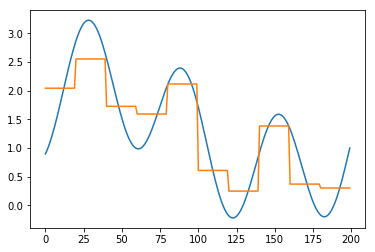

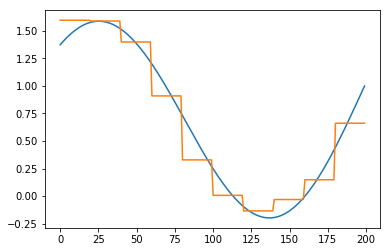

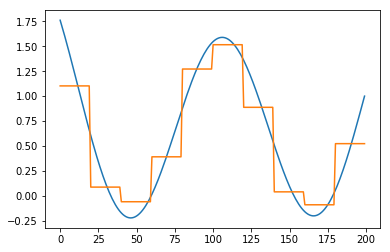

In [71]:
data = X_valid
pred = ef_with.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])